In [1]:
import random
import pathlib

import cv2
import einops #probably not needed
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

import tensorflow as tf
from tensorflow.keras import layers, models, losses
from tensorflow.keras.callbacks import EarlyStopping



1. Output not through sigmoid/softmax
- no transform
- softplus
2. Loss Function
- Not classification, cross entropy loss function
- mean squared error loss instead

In [2]:
regression_data1 =  [273.25, 173.52, 203.31, 227.25, 277.69, 213.21, 299.44, 360.26, 319.59, 372.49]
regression_data2 = [84.79, 71.87, 74.87, 77.27, 72.32, 76.91, 77.37, 85.43, 83.32, 83.50]
regression_data3 = [273.25, 84.79, 173.52, 71.87, 203.31, 74.87, 227.25, 77.27, 277.69, 72.32, 213.21, 76.91, 299.44, 77.37, 360.26, 85.43, 319.59, 83.32, 372.49, 83.50]
regression_data4 = [234.3158992, 238.3762008, 223.3395508 ,258.2964891, 308.3809155, 237.833691, 269.6809362, 240.1028949, 238.0344646, 289.8085463, 296.7480347, 254.8408521, 280.8549995, 305.4960162, 304.5373716, 332.1339075, 91.83076272, 102.9290284, 107.2722505, 118.4947244, 125.5493955, 143.4469968, 167.6710487, 168.928053, 161.7154215, 187.2395374, 208.7778182, 168.3711367, 209.7009893, 189.5577842, 209.69769, 198.7802618, 205.9488195, 209.9530789, 219.0467102, 221.408286, 221.3151488, 225.2788691, 230.7125019, 239.5862706, 236.1916802, 225.7250247, 240.7507197, 43.47757415, 40.49157473, 33.28122335, 32.0989265, 32.18500263, 22.77658, 22.39606886, 20.41376027, 22.6924993, 21.53471254, 23.88203075, 23.93024395, 21.85024589, 23.41806801, 28.39045941, 25.1815792, 26.33353658, 25.69546504, 24.17679749, 23.21302003]
data1 = "C:/Users/elika/Senior Design/Data/FeCl3-Videos-2_21_25/"
data2 = "C:/Users/elika/Senior Design/Data/Polymer-Videos-2_21_25"
data3 = "C:/Users/elika/Senior Design/Data/Combined-Videos-2_21_25"
data4 = "C:/Users/elika/Senior Design/Data/3_07-3_21-Videos"

In [3]:
#take the directory of videos and splits them into training, validation, and test sets
#Args: 
#    directory: the directory of videos
#    regression_data: the regression data for each video
#    splits: Dictionary specifying the training, validation, test, etc.
#Return:
#    Mapping of the directories containing the subsections of data.
#    Mapping of the regression data for each video.

def split_videos(directory, regression_data, splits):
    #get the list of videos
    videos = os.listdir(directory)

    if len(videos) != len(regression_data):
        raise ValueError("The number of videos and regression data points must be the same.")

    #shuffle the videos and regression data together
    zipped = list(zip(videos, regression_data))
    random.shuffle(zipped)
    videos, regression_data = zip(*zipped)
    #create a dictionary to hold the splits
    split_dict = {}
    #create a dictionary to hold the regression data
    regression_dict = {}
    #create a counter to keep track of the current split
    counter = 0
    #loop through the splits
    for split in splits:
        #get the number of videos for the current split
        num_videos = splits[split]
        #get the videos for the current split
        split_videos = videos[counter:counter + num_videos]
        #add the videos to the dictionary
        split_dict[split] = split_videos
        #get the regression data for the current split
        split_regression_data = regression_data[counter:counter + num_videos]
        #add the regression data to the dictionary
        regression_dict[split] = split_regression_data
        #increment the counter
        counter += num_videos

    #return the dictionaries
    return split_dict, regression_dict


In [4]:
def format_frames(frame, output_size, crop_coordinates=None):
  #1920x1080
  #720x720
  #edges are 600 on left and right, and 180 on top and bottom
  #crop the image to 720x720
  #adjust position by 80 left and 180 down
  #start crop at 520, 360
  """
  Pad and resize an image from a video, with optional off-center cropping.

  Args:
    frame: Image that needs to be resized and padded.
    output_size: Pixel size of the output frame image.
    crop_coordinates: Tuple (offset_height, offset_width, target_height, target_width)
                      specifying the region to crop. If None, the center is cropped.

  Return:
    Formatted frame with padding of specified output size.
  """
  if frame is None:
        print("Error: Received a None frame in format_frames")
        return None
  frame = tf.image.convert_image_dtype(frame, tf.float32)
  frame_height, frame_width, _ = frame.shape

  if crop_coordinates:
    offset_height, offset_width = crop_coordinates
    target_height, target_width = output_size
    if offset_height + target_height > frame_height or offset_width + target_width > frame_width:
            raise ValueError(
                f"Cropping coordinates exceed frame dimensions. "
                f"Frame size: ({frame_height}, {frame_width}), "
                f"Crop: (offset_height={offset_height}, offset_width={offset_width}, "
                f"target_height={target_height}, target_width={target_width})"
            )
    frame = tf.image.crop_to_bounding_box(frame, offset_height, offset_width, target_height, target_width)
  else:
    frame = tf.image.resize_with_crop_or_pad(frame, *output_size)
  frame = tf.image.resize(frame, (224, 224))
  return frame

In [5]:
def frames_from_video_file(video_path, n_frames, output_size = (720,720), frame_step = 3, crop_coordinates = (360, 520)):
  """
    Creates frames from each video file present for each category.

    Args:
      video_path: File path to the video.
      n_frames: Number of frames to be created per video file.
      output_size: Pixel size of the output frame image.

    Return:
      An NumPy array of frames in the shape of (n_frames, height, width, channels).
  """
  # Read each video frame by frame
  result = []
  src = cv2.VideoCapture(str(video_path))  
  if not src.isOpened():
        print(f"Error: Could not open video file {video_path}")
        return None

  video_length = src.get(cv2.CAP_PROP_FRAME_COUNT)
  #print(f"Video length of {video_path}: {video_length} frames")

  need_length = 1 + (n_frames - 1) * frame_step
  #print(f"Need length: {need_length} frames")

  #if need_length > video_length:
  #  start = 0
  #else:
  #  if max_start<20:
  #    max_start = video_length - need_length
  #  else:
  #    max_start = 20
  #  start = random.randint(0, max_start + 1)
  #print(f"Starting frame: {start}")

  src.set(cv2.CAP_PROP_POS_FRAMES, 10)
  # ret is a boolean indicating whether read was successful, frame is the image itself
  ret, frame = src.read()
  if not ret:
    print(f"Error1: Could not read frame from video file {video_path}")
    return None
  result.append(format_frames(frame, output_size, crop_coordinates))

  for _ in range(n_frames - 1):
    for _ in range(frame_step):
      ret, frame = src.read()
    if ret:
      frame = format_frames(frame, output_size, crop_coordinates)
      result.append(frame)
    else:
      print(f"Error2: Could not read frame from video file {video_path}")
      result.append(np.zeros_like(result[0]))
  src.release()
  result = np.array(result)[..., [2, 1, 0]]

  return result

In [6]:
class FrameGenerator:
  def __init__(self, path, regression_splits, n_frames, training = False):
    """ Returns a set of frames with their associated label. 

      Args:
        path: Video file paths.
        n_frames: Number of frames. 
        training: Boolean to determine if training dataset is being created.
    """
    self.path = path
    self.n_frames = n_frames
    self.training = training
    self.regression = regression_splits
    #self.class_names = sorted(set(p.name for p in self.path.iterdir() if p.is_dir()))
    #self.class_ids_for_name = dict((name, idx) for idx, name in enumerate(self.class_names))

  def __call__(self):
    pairs = list(zip(self.path, self.regression))

    if self.training:
      random.shuffle(pairs)

    for path, regression_value in pairs:
      if path.suffix not in ['.mp4', '.avi', '.mov']:  # Add other supported video formats if needed
        print(f"Skipping non-video file: {path}")
        continue
      #print(f"Processing video file: {path.resolve()}")
      video_frames = frames_from_video_file(path, self.n_frames) 
      if video_frames is not None:
        yield video_frames, regression_value
      else:
        print(f"Failed to extract frames from {path}")

In [7]:
HEIGHT = 224
WIDTH = 224

In [8]:
class ResizeVideo(keras.layers.Layer):
  def __init__(self, height, width):
    super().__init__()
    self.height = height
    self.width = width
    self.resizing_layer = layers.Resizing(self.height, self.width)

  def call(self, video):
    """
      Use the einops library to resize the tensor.  

      Args:
        video: Tensor representation of the video, in the form of a set of frames.

      Return:
        A downsampled size of the video according to the new height and width it should be resized to.
    """
    # b stands for batch size, t stands for time, h stands for height, 
    # w stands for width, and c stands for the number of channels.
    old_shape = einops.parse_shape(video, 'b t h w c')
    images = einops.rearrange(video, 'b t h w c -> (b t) h w c')
    images = self.resizing_layer(images)
    videos = einops.rearrange(
        images, '(b t) h w c -> b t h w c',
        t = old_shape['t'])
    return videos

In [9]:
class PrintLayer(layers.Layer):
    def call(self, inputs):
        print(f"Shape of data before Flatten layer: {inputs.shape}")
        return inputs

In [10]:
def input_time(time, n_frames):
    """
        Create a time input for the model.
    
        Args:
        time: Time input.
        n_frames: Number of frames.
    
        Return:
        time_input: Time input.
        n_frames: Number of frames.
        frame_step: The frame step.
        max_delay: The maximum delay.
    """
    
    time_input = np.zeros((n_frames, 1))
    frame_step = int(time / (n_frames - 1))
    max_delay = int(0.1*time)
    time_input[:, 0] = np.linspace(0, max_delay, n_frames)
    return time_input, n_frames, frame_step, max_delay

In [11]:
data = data4  # Choose the appropriate data directory for your use case
regression_data = regression_data4  # Choose the appropriate regression data for your use case

#print files in data
print(f"Files in {data}:")
for file in os.listdir(data):
    print(file)

#get regression_data length
print(f"Length of regression_data: {len(regression_data)}")
data_size = len(regression_data)
train_split = int(0.6 * data_size)
test_split = int(0.2 * data_size)
val_split = data_size - train_split - test_split
print(f"Train split: {train_split}")
print(f"Validation split: {val_split}")
print(f"Test split: {test_split}")

subset_paths, regression_splits = split_videos(  
                        directory = data,
                        regression_data = regression_data,
                        splits = {"train": train_split, "val": val_split, "test": test_split})
#[43, 52, 63, 59, 75, 66, 62, 70, 80, 102]
#[102, 110, 43, 54, 52, 65, 63, 66, 59, 74, 75, 80, 66, 78, 62, 84, 70, 92, 80, 101]
# 1 2 3 4 5 6 7 8 9 10
print(f"Subset paths: {subset_paths}")
print(f"Regression splits: {regression_splits}")

Files in C:/Users/elika/Senior Design/Data/3_07-3_21-Videos:
recording_20250307_105315.mp4
recording_20250307_110430.mp4
recording_20250307_111221.mp4
recording_20250307_111850.mp4
recording_20250307_112535.mp4
recording_20250307_113356.mp4
recording_20250307_114629.mp4
recording_20250307_115231.mp4
recording_20250307_115900.mp4
recording_20250307_120542.mp4
recording_20250307_121145.mp4
recording_20250307_121749.mp4
recording_20250307_122417.mp4
recording_20250307_123042.mp4
recording_20250307_123640.mp4
recording_20250307_124259.mp4
recording_20250307_125213.mp4
recording_20250307_125605.mp4
recording_20250307_125949.mp4
recording_20250307_130337.mp4
recording_20250307_130734.mp4
recording_20250307_131111.mp4
recording_20250307_131449.mp4
recording_20250307_131834.mp4
recording_20250307_132239.mp4
recording_20250307_132635.mp4
recording_20250307_133051.mp4
recording_20250307_133643.mp4
recording_20250307_134028.mp4
recording_20250307_134800.mp4
recording_20250321_114619.mp4
recording

In [12]:
n_frames = 20
batch_size = 8

output_signature = (tf.TensorSpec(shape = (None, None, None, 3), dtype = tf.float32),
                    tf.TensorSpec(shape = (), dtype = tf.int16))

base_dir = pathlib.Path(data)

#convert subset paths to pathlib objects
#subset_paths = {key: pathlib.Path(value) for key, value in subset_paths.items()}
subset_paths = {key: [base_dir / pathlib.Path(p).name for p in value] for key, value in subset_paths.items()}

train_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['train'], regression_splits['train'], n_frames, training=True),
                                          output_signature = output_signature)


# Batch the data
train_ds = train_ds.batch(batch_size)

val_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['val'], regression_splits['val'], n_frames),
                                        output_signature = output_signature)
val_ds = val_ds.batch(batch_size)

test_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['test'], regression_splits['test'], n_frames),
                                         output_signature = output_signature)

test_ds = test_ds.batch(batch_size)

print(f"Number of batches in train_ds: {len(list(train_ds))}")
print(f"Number of batches in val_ds: {len(list(val_ds))}")
print(f"Number of batches in test_ds: {len(list(test_ds))}")

Number of batches in train_ds: 5
Number of batches in val_ds: 2
Number of batches in test_ds: 2


(TensorSpec(shape=(None, None, None, None, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int16, name=None))


In [13]:
print(subset_paths['train'])
print(regression_splits['train'])
print(subset_paths['val'])
print(regression_splits['val'])
print(subset_paths['test'])
print(regression_splits['test'])
#[43, 52, 63, 59, 75, 66, 62, 70, 80, 102]

[WindowsPath('C:/Users/elika/Senior Design/Data/3_07-3_21-Videos/recording_20250321_121106.mp4'), WindowsPath('C:/Users/elika/Senior Design/Data/3_07-3_21-Videos/recording_20250307_130337.mp4'), WindowsPath('C:/Users/elika/Senior Design/Data/3_07-3_21-Videos/recording_20250321_135740.mp4'), WindowsPath('C:/Users/elika/Senior Design/Data/3_07-3_21-Videos/recording_20250321_134611.mp4'), WindowsPath('C:/Users/elika/Senior Design/Data/3_07-3_21-Videos/recording_20250307_131834.mp4'), WindowsPath('C:/Users/elika/Senior Design/Data/3_07-3_21-Videos/recording_20250307_134800.mp4'), WindowsPath('C:/Users/elika/Senior Design/Data/3_07-3_21-Videos/recording_20250307_124259.mp4'), WindowsPath('C:/Users/elika/Senior Design/Data/3_07-3_21-Videos/recording_20250307_115900.mp4'), WindowsPath('C:/Users/elika/Senior Design/Data/3_07-3_21-Videos/recording_20250307_110430.mp4'), WindowsPath('C:/Users/elika/Senior Design/Data/3_07-3_21-Videos/recording_20250307_112535.mp4'), WindowsPath('C:/Users/elika/S

In [141]:
# Check the shape of the elements in train_ds
for frames, label in train_ds.take(1):
    print(f"Shape of frames in train_ds: {frames.shape}")
    print(f"Shape of label in train_ds: {label.shape}")

print("label: ", label)

# Check the shape of the elements in val_ds
for frames, label in val_ds.take(1):
    print(f"Shape of frames in val_ds: {frames.shape}")
    print(f"Shape of label in val_ds: {label.shape}")

print("label: ", label)

# Check the shape of the elements in test_ds
for frames, label in test_ds.take(2):
    print(f"Shape of frames in test_ds: {frames.shape}")
    print(f"Shape of label in test_ds: {label.shape}")

print("label: ", label)

Shape of frames in train_ds: (8, 20, 224, 224, 3)
Shape of label in train_ds: (8,)
label:  tf.Tensor([221 168 258 308  23  23 240 236], shape=(8,), dtype=int16)
Shape of frames in val_ds: (8, 20, 224, 224, 3)
Shape of label in val_ds: (8,)
label:  tf.Tensor([ 26 221  32  23 234 208  21  23], shape=(8,), dtype=int16)
Shape of frames in test_ds: (8, 20, 224, 224, 3)
Shape of label in test_ds: (8,)
Shape of frames in test_ds: (4, 20, 224, 224, 3)
Shape of label in test_ds: (4,)
label:  tf.Tensor([239  24 209  40], shape=(4,), dtype=int16)


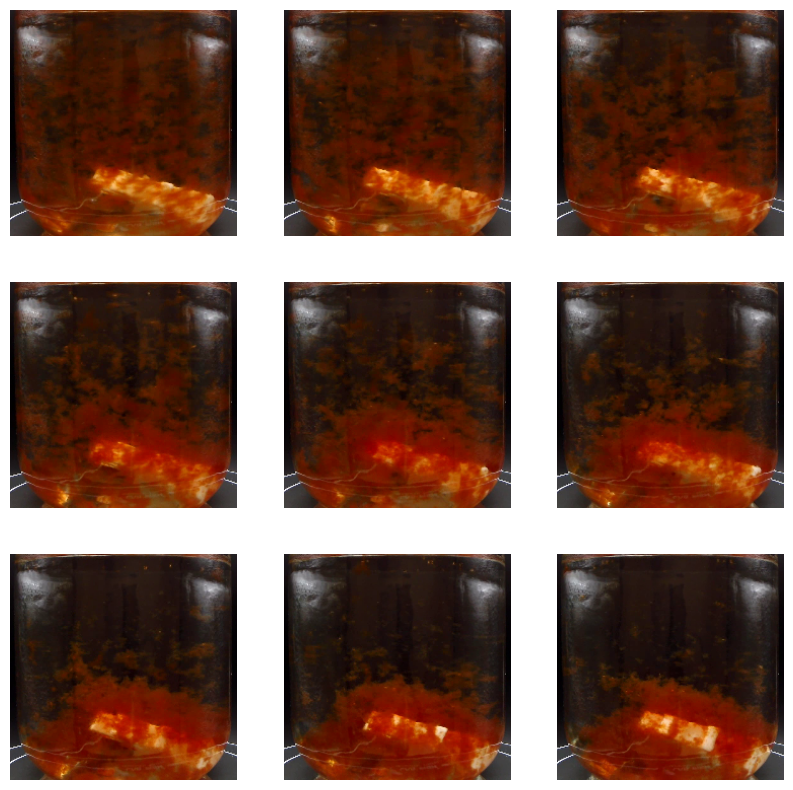

In [148]:
#print frames from video one
plt.figure(figsize=(10, 10))

for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(frames[3][i])
    plt.axis("off")



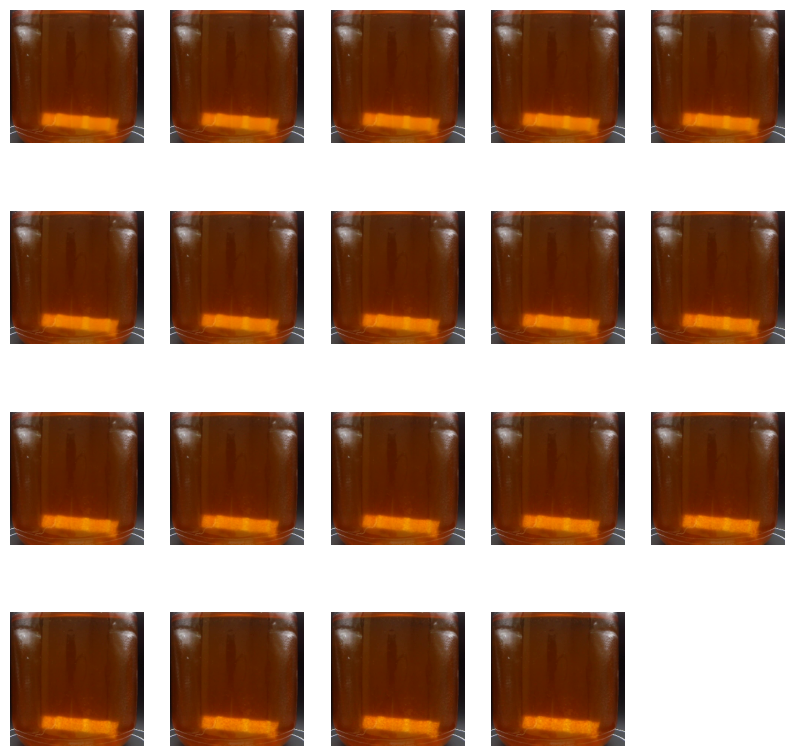

In [16]:
#print frames from video one
plt.figure(figsize=(10, 10))
for i in range(19):
    ax = plt.subplot(4, 5, i + 1)
    plt.imshow(frames[0][i])
    plt.axis("off")

(-0.5, 223.5, 223.5, -0.5)

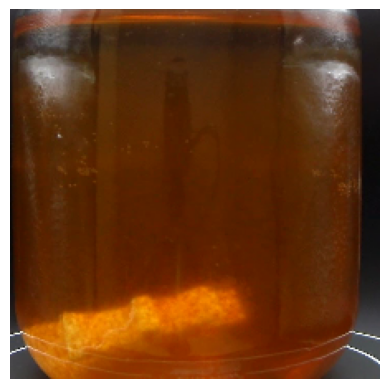

In [137]:
#print one frame from video one
plt.imshow(frames[5][19])
plt.axis("off")


In [17]:
#resize the video
resize_video = ResizeVideo(HEIGHT, WIDTH)
frames = resize_video(frames)


In [18]:
model = models.Sequential()

model.add(layers.Input(shape=(n_frames, HEIGHT, WIDTH, 3)))
model.add(layers.Conv3D(32, (3, 3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling3D((1, 2, 2)))
model.add(layers.Conv3D(64, (3, 3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling3D((1, 2, 2)))
model.add(layers.Conv3D(64, (3, 3, 3), activation='relu', padding='same'))

In [19]:
#model.add(PrintLayer())
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d (Conv3D)                 │ (None, 20, 224, 224,   │         2,624 │
│                                 │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 20, 112, 112,   │             0 │
│                                 │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 20, 112, 112,   │        55,360 │
│                                 │ 64)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 20, 56, 56, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_2 (Conv3D)               │ (None, 20, 56, 56, 64) │       110,656 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 168,640 (658.75 KB)

 Trainable params: 168,640 (658.75 KB)

 Non-trainable params: 0 (0.00 B)

In [20]:
#model.add(PrintLayer())
model.add(layers.Reshape((n_frames * 56 * 56 * 64,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='softplus'))
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d (Conv3D)                 │ (None, 20, 224, 224,   │         2,624 │
│                                 │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 20, 112, 112,   │             0 │
│                                 │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 20, 112, 112,   │        55,360 │
│                                 │ 64)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 20, 56, 56, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_2 (Conv3D)               │ (None, 20, 56, 56, 64) │       110,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 4014080)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │   256,901,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 257,069,889 (980.64 MB)

 Trainable params: 257,069,889 (980.64 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
frames, label = next(iter(train_ds))
model.build(frames)

In [22]:
train_ds = train_ds.repeat()  # Repeat the dataset for training
steps_per_epoch = len(subset_paths['train']) // batch_size

val_ds = val_ds.repeat()  # Repeat the validation dataset
val_steps = len(subset_paths['val']) // batch_size



In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

model.compile(optimizer='adam',
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['mae'])

history = model.fit(
    x=train_ds, 
    epochs=50, 
    validation_data=val_ds,
    steps_per_epoch=steps_per_epoch,
    validation_steps=val_steps,
    callbacks=[early_stopping]
)

Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 59s 11s/step - loss: 29177.3008 - mae: 143.4107 - val_loss: 16662.3164 - val_mae: 88.1310
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 40s 12s/step - loss: 25330.8066 - mae: 127.9659 - val_loss: 11994.0986 - val_mae: 97.7098
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 30s 8s/step - loss: 9841.2012 - mae: 84.2919 - val_loss: 7072.1260 - val_mae: 82.2404
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 30s 8s/step - loss: 11706.3682 - mae: 94.3915 - val_loss: 7264.8438 - val_mae: 72.9901
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 31s 8s/step - loss: 10030.4365 - mae: 80.7851 - val_loss: 7250.0498 - val_mae: 78.3266
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 34s 9s/step - loss: 7015.7778 - mae: 70.9386 - val_loss: 6512.0059 - val_mae: 68.8957
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 32s 9s/step - loss: 4935.6787 - mae: 58.9539 - val_loss: 2283.8015 - val_mae: 43.2950
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 32s 9s/step - loss: 4707.9321 - mae: 59.2782 - val_loss: 577.9925 - val_mae: 22.3204
Epoch 9/50
4/4 

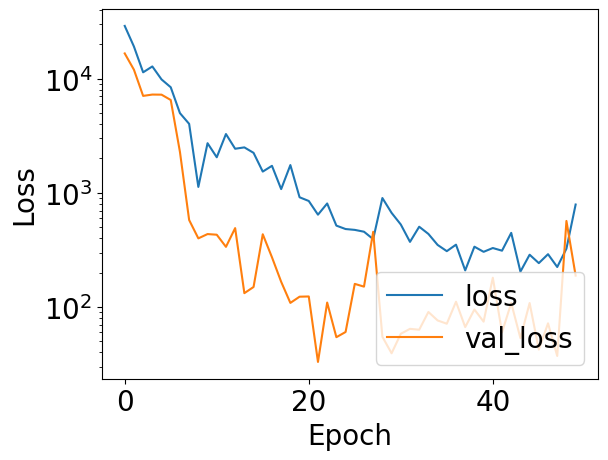

In [ ]:
import seaborn as sns

#plot the training and validation loss with log scale
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')  # Set y-axis to log scale
plt.legend(loc='lower right')
plt.show()

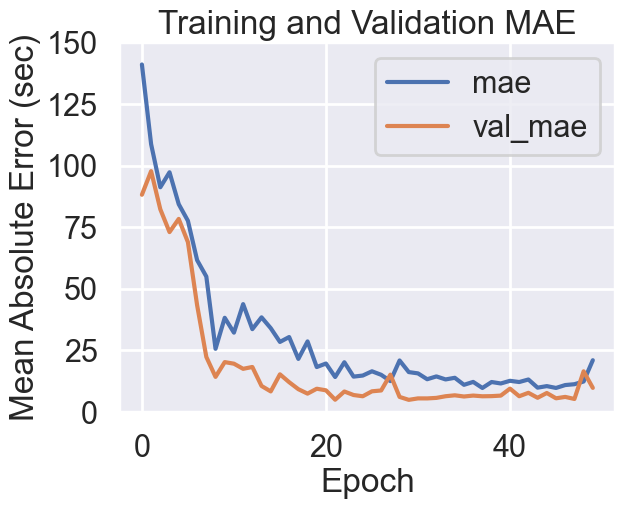

In [152]:
#plot the training and validation mae
plt.plot(history.history['mae'], label='mae')
plt.plot(history.history['val_mae'], label = 'val_mae')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error (sec)')
plt.ylim([0, 150])
plt.legend(loc='upper right')
sns.set_theme("poster")
plt.title('Training and Validation MAE')
#change fontsize
#plt.rcParams.update({'font.size': 20})
plt.show()


In [30]:
test_loss, test_mae = model.evaluate(test_ds, verbose=2)

2/2 - 6s - 3s/step - loss: 834.9978 - mae: 22.9969


C:\Users\elika\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


In [149]:
print(test_loss, test_mae)


834.997802734375 22.996871948242188


In [32]:
predictions = model.predict(test_ds)
print(predictions)
#[277  76 360 173]

2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step
[[308.93256 ]
 [141.55737 ]
 [244.9759  ]
 [290.80408 ]
 [222.6083  ]
 [162.77869 ]
 [225.02725 ]
 [122.221985]
 [241.4303  ]
 [ 25.903248]
 [237.98013 ]
 [ 40.742645]]


In [121]:
print(sum((299.44, 85.43, 173.52, 84.79, 76.91, 273.25, 83.32, 372.49, 72.32, 77.27, 71.87, 77.37))/12)
print(sum([299.44, 173.52, 273.25, 372.49, ])/4)
print(sum([85.43, 84.79, 76.91, 83.32, 72.32, 77.27, 71.87, 77.37])/8)

145.66499999999996
279.675
78.66000000000001


In [49]:
#calculate the rmse
targets = [305.4960162, 107.2722505, 205.9488195, 237.833691, 209.7009893, 125.5493955, 187.2395374, 102.9290284, 239.5862706, 24.17679749, 209.69769, 40.49157473]

def rmse(predictions, targets):
    return np.sqrt(np.mean(((predictions - targets) ** 2)))

print(rmse(predictions, targets))

121.89296641659821


In [ ]:
#calculate the average margin of error
moe = 0
for i in range(len(predictions)):
    moe += abs(predictions[i] - targets[i])/targets[i]
moe = moe/len(predictions)
print(moe)



[0.14254935]


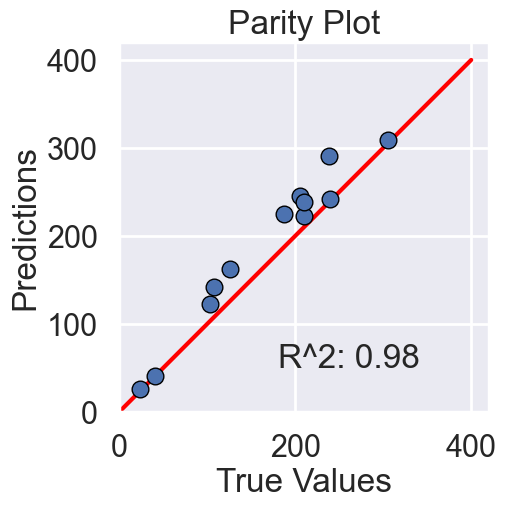

In [ ]:
#parity plot
#plot x=y line
sns.set_theme("poster")
plt.plot([0, 400], [0, 400], color='red', linewidth=3)
#plt.rcParams.update({'lines.markersize': 10})
plt.scatter(regression_splits['test'], predictions.flatten(), linewidths=1, edgecolors='black', zorder=2)
plt.xlabel('True Values (sec)')
plt.ylabel('Predictions (sec)')
plt.axis('equal')
plt.axis('square')
plt.xlim([0, plt.xlim()[1]])
plt.ylim([0, plt.ylim()[1]])
plt.title('Parity Plot')

# Ensure predictions is flattened and matches the length of regression_splits['test']
predictions_flattened = predictions.flatten()
if len(regression_splits['test']) != len(predictions_flattened):
	raise ValueError(f"Mismatch in lengths: regression_splits['test'] has length {len(regression_splits['test'])}, "
					 f"but predictions has length {len(predictions_flattened)}")

# Calculate and show r^2
r2 = np.corrcoef(regression_splits['test'], predictions_flattened)[0, 1]
plt.text(180, 50, f"R^2: {r2:.2f}", fontsize=24)

plt.show()

In [2]:
import pandas as pd
# load model splits from CSV

model_path = "C:/Users/elika/Senior Design/Results/3_07-3_21-3_25-Videos_model2/"
model = models.load_model(model_path + "model/video_model.keras")

model_splits = pd.read_csv(model_path + 'model/model_splits.csv')



In [ ]:
#drop the first 4 columns
model_splits = model_splits.drop(model_splits.columns[:4], axis=1)

#turn content of each column into a list
video_paths = model_splits['video_path'].tolist()
regression_data = model_splits['regression_data'].tolist()

,test_paths,test
0,C:\Users\elika\Senior Design\Data\3_07-3_21-3_...,240.102895
1,C:\Users\elika\Senior Design\Data\3_07-3_21-3_...,296.394764
2,C:\Users\elika\Senior Design\Data\3_07-3_21-3_...,21.850246
3,C:\Users\elika\Senior Design\Data\3_07-3_21-3_...,60.076303
4,C:\Users\elika\Senior Design\Data\3_07-3_21-3_...,161.715421
5,C:\Users\elika\Senior Design\Data\3_07-3_21-3_...,21.534713
6,C:\Users\elika\Senior Design\Data\3_07-3_21-3_...,269.680936
7,C:\Users\elika\Senior Design\Data\3_07-3_21-3_...,168.928053
8,C:\Users\elika\Senior Design\Data\3_07-3_21-3_...,281.994029
9,C:\Users\elika\Senior Design\Data\3_07-3_21-3_...,91.830763
